In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Declare train_data
dataset = pd.read_csv(f"/content/drive/MyDrive/2023-1/DL/Project/Gangnam_divided/107.csv", index_col = 0)
dataset.head()

,kaptCode,electC,electP,Date
107,A13589802,4799.497125,83646.626198,201601.0
107,A13589802,10638.508626,78004.287540,201602.0
107,A13589802,14182.824920,75477.255591,201603.0
107,A13589802,3613.501278,71805.108626,201604.0
107,A13589802,427.665176,80265.479233,201605.0


In [4]:
dataset['Date'] = pd.to_datetime(dataset['Date'], format = "%Y%m").dt.normalize()
dataset.head()

,kaptCode,electC,electP,Date
107,A13589802,4799.497125,83646.626198,2016-01-01
107,A13589802,10638.508626,78004.287540,2016-02-01
107,A13589802,14182.824920,75477.255591,2016-03-01
107,A13589802,3613.501278,71805.108626,2016-04-01
107,A13589802,427.665176,80265.479233,2016-05-01


In [5]:
len(dataset)

84

In [6]:
train_data = dataset.iloc[:60,:]
test_data = dataset.iloc[60:,:]
print(train_data.shape, test_data.shape)

(60, 4) (24, 4)


In [17]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
C_scaled = sc.fit_transform(train_data.iloc[:, 1:2].values.reshape(-1,1))

In [18]:
def makeXYtrain(train, past_date= 10):
  X_train = []
  y_train = []
  for i in range(past_date, len(train)):
      X_train.append(train[i-past_date:i, 0])
      y_train.append(train[i, 0])
  X_train, y_train = np.array(X_train), np.array(y_train)
  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
  return X_train, y_train

In [48]:
cX_train, cy_train = makeXYtrain(C_scaled, past_date = 10)
print(cX_train.shape, cy_train.shape)

(50, 10, 1) (50,)


In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.metrics import mean_squared_error

In [21]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (cX_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50 ))
model.add(Dense(units = 1))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
def trainModel(X_train, y_train, model, optimizer= 'adam', loss='mean_squared_error', epoch=50, batch_size=32):
  model.compile(optimizer = optimizer, loss = loss)
  model.fit(X_train, y_train, epochs = epoch, batch_size = batch_size)

In [32]:
def makeXtest(dataset, test_data, past_date= 100, cp = "c"):
  if(cp == "c"):
    total_data = dataset.iloc[:,1:2]
  else: 
    total_data = dataset.iloc[:,2:3]
  input = total_data[len(total_data) - len(test_data)- past_date:]
  test_scaled = sc.fit_transform(input.values.reshape(-1,1))
  X_test, y_test = makeXYtrain(test_scaled, past_date = past_date)
  return X_test

In [25]:
trainModel(cX_train, cy_train, model = model, epoch = 300, batch_size = 32)

Epoch 1/300
2/2 [==============================] - 4s 12ms/step - loss: 0.0302
Epoch 2/300
2/2 [==============================] - 0s 11ms/step - loss: 0.0253
Epoch 3/300
2/2 [==============================] - 0s 11ms/step - loss: 0.0238
Epoch 4/300
2/2 [==============================] - 0s 11ms/step - loss: 0.0249
Epoch 5/300
2/2 [==============================] - 0s 11ms/step - loss: 0.0263
Epoch 6/300
2/2 [==============================] - 0s 10ms/step - loss: 0.0243
Epoch 7/300
2/2 [==============================] - 0s 9ms/step - loss: 0.0241
Epoch 8/300
2/2 [==============================] - 0s 10ms/step - loss: 0.0237
Epoch 9/300
2/2 [==============================] - 0s 9ms/step - loss: 0.0243
Epoch 10/300
2/2 [==============================] - 0s 13ms/step - loss: 0.0226
Epoch 11/300
2/2 [==============================] - 0s 12ms/step - loss: 0.0238
Epoch 12/300
2/2 [==============================] - 0s 11ms/step - loss: 0.0241
Epoch 13/300
2/2 [==============================] -

In [33]:
cX_test= makeXtest(dataset, test_data, past_date = 10, cp = "c")
cX_test.shape

(24, 10, 1)

In [34]:
c_predicted = model.predict(cX_test)
c_predicted = sc.inverse_transform(c_predicted)

1/1 [==============================] - 0s 25ms/step


In [83]:
def plotResult(test_data, predicted, num):
  plt.figure(figsize=(10, 4))
  plt.plot(test_data.values, color = "skyblue", label = "real")
  plt.plot(predicted, color = 'pink', label = "predicted")
  plt.title(f"Common_Electricity_Usage {num}")
  plt.xlabel("time")
  plt.ylabel("electricity usage")
  plt.legend()
  plt.savefig(f"DL_test{num}.png")
  plt.show()

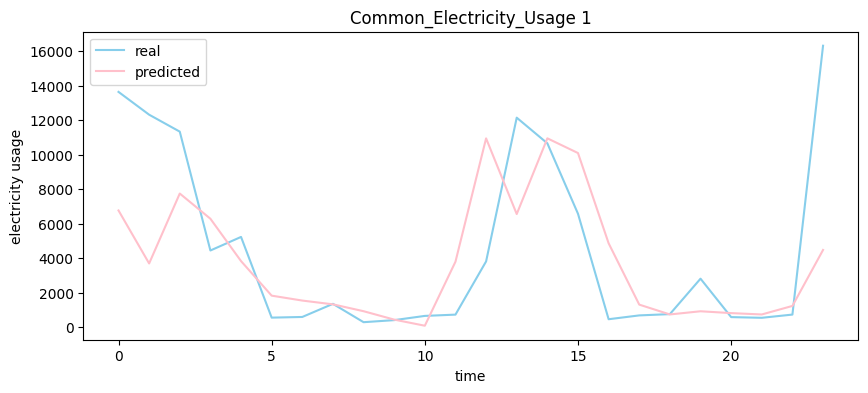

In [84]:
plotResult(test_data.iloc[:, 1:2], c_predicted, 1)

In [67]:
sc2 = MinMaxScaler(feature_range = (0, 1))
P_scaled = sc2.fit_transform(train_data.iloc[:, 2:3].values.reshape(-1,1))
pX_train, py_train = makeXYtrain(P_scaled, past_date = 10)
print(pX_train.shape, py_train.shape)

(50, 10, 1) (50,)


In [77]:
modelp = Sequential()
modelp.add(LSTM(units = 80, return_sequences = True, input_shape = (pX_train.shape[1], 1)))
modelp.add(Dropout(0.2))
modelp.add(LSTM(units = 50, return_sequences = True))
modelp.add(Dropout(0.2))
modelp.add(LSTM(units = 50 ))
modelp.add(Dense(units = 1))

print(modelp.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 10, 80)            26240     
                                                                 
 dropout_10 (Dropout)        (None, 10, 80)            0         
                                                                 
 lstm_20 (LSTM)              (None, 10, 50)            26200     
                                                                 
 dropout_11 (Dropout)        (None, 10, 50)            0         
                                                                 
 lstm_21 (LSTM)              (None, 50)                20200     
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 72,691
Trainable params: 72,691
Non-trai

In [78]:
trainModel(pX_train, py_train, model = modelp, epoch = 300, batch_size = 16)

Epoch 1/300
4/4 [==============================] - 4s 11ms/step - loss: 0.0346
Epoch 2/300
4/4 [==============================] - 0s 12ms/step - loss: 0.0295
Epoch 3/300
4/4 [==============================] - 0s 12ms/step - loss: 0.0265
Epoch 4/300
4/4 [==============================] - 0s 13ms/step - loss: 0.0256
Epoch 5/300
4/4 [==============================] - 0s 15ms/step - loss: 0.0259
Epoch 6/300
4/4 [==============================] - 0s 11ms/step - loss: 0.0242
Epoch 7/300
4/4 [==============================] - 0s 12ms/step - loss: 0.0239
Epoch 8/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0235
Epoch 9/300
4/4 [==============================] - 0s 12ms/step - loss: 0.0226
Epoch 10/300
4/4 [==============================] - 0s 12ms/step - loss: 0.0222
Epoch 11/300
4/4 [==============================] - 0s 16ms/step - loss: 0.0220
Epoch 12/300
4/4 [==============================] - 0s 12ms/step - loss: 0.0220
Epoch 13/300
4/4 [==============================]

In [79]:
pX_test= makeXtest(dataset, test_data, past_date = 10, cp = "p")
print(pX_test.shape)
p_predicted = model.predict(pX_test)
p_predicted = sc2.inverse_transform(p_predicted)

(24, 10, 1)
1/1 [==============================] - 0s 17ms/step


In [85]:
def plotResult(test_data, predicted, num):
  plt.figure(figsize=(10, 4))
  plt.plot(test_data.values, color = "skyblue", label = "real")
  plt.plot(predicted, color = 'pink', label = "predicted")
  plt.title(f"Private_Electricity_Usage {num}")
  plt.xlabel("time")
  plt.ylabel("electricity usage")
  plt.legend()
  plt.savefig(f"DL_test{num}.png")
  plt.show()

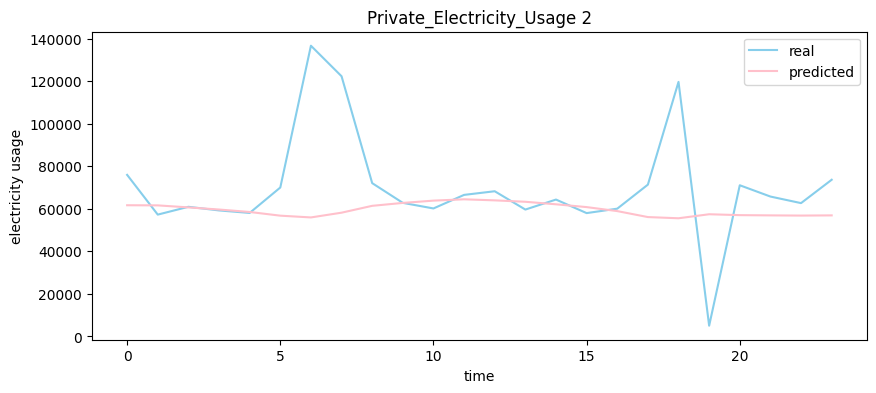

In [86]:
plotResult(test_data.iloc[:, 2:3], p_predicted, 2)